In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
data = pd.read_csv('lenta-ru-news.csv', encoding='cp1251')

In [3]:
data

,url,title,text,topic,tags
0,https://lenta.ru/news/2019/04/30/telega/,«Сталингулаг» верифицировали в Telegram,"Telegram-канал «Сталингулаг» сообщил, что созд...",NaN,Coцсети
1,https://lenta.ru/news/2019/05/01/habib_papa/,Отец Нурмагомедова рассказал о «допинге» сына,Тренер и отец бойца смешанного стиля (ММА) Хаб...,NaN,Бокс и ММА
2,https://lenta.ru/news/2019/05/01/russian_austria/,Президент Австрии рассказал о русских корнях,Президент Австрии Александер ван дер Беллен пр...,NaN,Политика
3,https://lenta.ru/news/2019/05/01/hamon/,Покусившейся на хамон мясной компании объявили...,Пользователи социальных сетей решили объявить ...,NaN,Coцсети
4,https://lenta.ru/news/2019/05/01/kurs/,Рассчитан курс рубля на лето,Рубль может ослабнуть к периоду летних отпуско...,NaN,Деньги
...,...,...,...,...,...
18306,https://lenta.ru/news/2019/12/30/trump/,Публикация об осведомителе по делу об импичмен...,Пост президента США Дональда Трампа с именем п...,NaN,Coцсети
18307,https://lenta.ru/news/2019/12/30/baturina/,Самую богатую женщину России потеряли,Дело о клевете в отношении вдовы бывшего мэра ...,NaN,Бизнес
18308,https://lenta.ru/news/2019/12/30/burning/,Авиаудар США по Ираку сняли на видео,Видео авиаудара американских ВВС по позициям г...,NaN,Конфликты
18309,https://lenta.ru/news/2019/12/30/podval/,Жители российского города пришли поесть в «Меч...,В одном из кафе Астрахани под названием «Мечта...,NaN,Общество


In [4]:
with open('entities.txt', 'r', encoding='utf-8') as f:
    entities = list(f.read().split('\n'))

Осуществляем препроцессинг текстов:

In [132]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

In [133]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [5]:
rs = np.random.RandomState(42)

i=0
data_processed = []
with open('preprocssed_data.txt', 'a') as g:
    for news in data.sample(n=3000, random_state=36).to_numpy():
        data_processed.append(preprocess_text(news[2])
        
data_processed = np.array(data_processed)

Теперь можно построить граф связей упоминания наименований из списка entities. Вышло так, что циклов нет в графе, и удалять ничего не нужно.

In [15]:
n = len(entities)
entities_matrix = np.zeros((n, 3000))
for i in range(n):
    for j in range(len(data_processed)):
        if entities[i] in data_processed[j]:
            entities_matrix[i][j] = 1

X = pd.DataFrame.from_items(zip(entities, entities_matrix))

c:\users\adaln\env\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


In [25]:
import networkx as nx
from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest

variable_types = {x:'d' for x in entities}
mi_test = MutualInformationTest([entities[0]],[entities[1]],
                                [entities[2]], X, alpha=0.05, variable_types=variable_types)

ic_algorithm = IC(MutualInformationTest, alpha=0.05)
graph = ic_algorithm.search(X, variable_types)

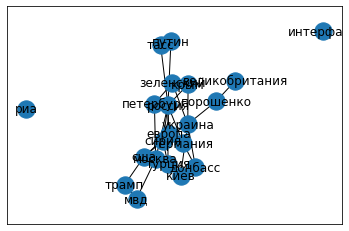

In [65]:
nx.draw_networkx(graph)

In [37]:
for e in graph.edges(data=True):
    print(e)

('украина', 'киев', {'marked': False, 'arrows': ['украина', 'киев']})
('украина', 'донбасс', {'marked': False, 'arrows': ['украина', 'украина']})
('украина', 'европа', {'marked': False, 'arrows': ['украина', 'украина', 'украина', 'украина', 'украина', 'украина', 'европа', 'европа']})
('украина', 'порошенко', {'marked': False, 'arrows': ['украина', 'украина', 'украина', 'порошенко']})
('украина', 'зеленский', {'marked': False, 'arrows': ['украина', 'украина']})
('украина', 'крым', {'marked': False, 'arrows': ['украина', 'украина', 'украина', 'украина', 'крым']})
('украина', 'сирия', {'marked': False, 'arrows': ['украина', 'украина', 'сирия', 'сирия', 'сирия']})
('сша', 'трамп', {'marked': False, 'arrows': ['сша', 'сша']})
('сша', 'европа', {'marked': False, 'arrows': ['сша', 'сша', 'европа', 'европа', 'европа']})
('сша', 'сирия', {'marked': False, 'arrows': ['сша', 'сша', 'сирия', 'сирия']})
('россия', 'москва', {'marked': False, 'arrows': ['россия', 'россия', 'россия', 'россия', 'росси

In [44]:
d = {i : 0 for i in entities}
for e in graph.edges(data=True):
    d[e[0]] += 1
    d[e[1]] += 1
d

{'украина': 7,
 'сша': 3,
 'россия': 9,
 'москва': 4,
 'киев': 3,
 'тасс': 2,
 'трамп': 2,
 'риа': 0,
 'донбасс': 3,
 'европа': 4,
 'порошенко': 2,
 'зеленский': 2,
 'путин': 2,
 'крым': 2,
 'мвд': 2,
 'сирия': 4,
 'турция': 2,
 'германия': 3,
 'петербург': 3,
 'интерфакс': 0,
 'великобритания': 1}

Получаем, что для данной случайной подвыборки центральная сущность - "россия".

Оценим ACE при условия упоминания и не упоминания сущностей, от которых зависит центральная сущность. Для нашей подвыборки получаем максимальный ACE для сущности "путин", что вполне логично:

In [80]:
for z in dependencies:
    effect = CausalEffect(X, [z], ['россия'], 
                          variable_types={x:'u' for x in entities},
                          admissable_set=[])

    mention = pd.DataFrame({z: [1], 'россия': [1]})
    no_mention = pd.DataFrame({z: [0], 'россия': [1]})

    print(z, effect.pdf(mention) - effect.pdf(no_mention))

москва 0.21464700556741473
тасс 0.22799448719252619
европа 0.18191029331596065
путин 0.4578094190677252
крым 0.3408067515595565
сирия 0.3123957381314742
турция 0.3126789350448263
германия 0.2987140780523676
петербург 0.1956632275727953


Выпишем теперь оценки вероятностей упоминания центральной сущности при условии упоминания (и при отсутствии упоминания) сущностей, от которых она зависит:

In [81]:
for z in dependencies:
    p_mention = np.round(np.dot(X['россия'].values, X[z].values)/3000, 3)
    p_no_mention = np.round(np.dot(X['россия'].values, 1 - X[z].values)/3000, 3)
    print("Probability({name}): mention = {p1}, no mention = {p2}".format(name=z, p1=p_mention, p2=p_no_mention))

Probability(москва): mention = 0.117, no mention = 0.34
Probability(тасс): mention = 0.072, no mention = 0.386
Probability(европа): mention = 0.041, no mention = 0.416
Probability(путин): mention = 0.07, no mention = 0.387
Probability(крым): mention = 0.03, no mention = 0.427
Probability(сирия): mention = 0.02, no mention = 0.437
Probability(турция): mention = 0.02, no mention = 0.438
Probability(германия): mention = 0.031, no mention = 0.426
Probability(петербург): mention = 0.032, no mention = 0.425
